Import required libraries

In [1]:
from navground import sim,core
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import scipy.spatial.distance as dist
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr, iqr, mannwhitneyu
import seaborn as sns

# import created library for experiments.
import importlib.util
from pathlib import Path
ruta_archivo = Path("../..") / "functions.py"
spec = importlib.util.spec_from_file_location("functions", ruta_archivo)
fu = importlib.util.module_from_spec(spec)
spec.loader.exec_module(fu)

As we want to compare both behaviours through the time series of the persistent entropy of the space of each simulation, we generate 10 simulations for each behaviour, where the safety_margin variable is not fixed, but uniformly distributed.
We then generate the time series of the simulations for each behaviour to see if there are indeed differences in their behaviour.

First, for human-life behavior

In [2]:
time_instances=3000
robots=20
time_step=0.1
safetyMargin=0.25
sideLength=8
radioRobot=0.08
radioVision = 5
simulations = 10
scenario = "Cross"

yaml = f"""
steps: {time_instances}
time_step: {time_step}
runs: {simulations}
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
record_efficacy: true
scenario:
    type: {scenario}
    agent_margin: 0.1
    side: {sideLength}
    target_margin: 0.5
    tolerance: 0.25
    groups:
      -
        type: thymio 
        number: {robots}
        radius: {radioRobot}
        control_period: 0.1
        speed_tolerance: 0.02
        kinematics:
          type: 2WDiff
          wheel_axis: 0.094
          max_speed: 0.166
        behavior:
          type: HL
          optimal_speed: 0.12
          horizon: 5.0
          tau: 0.5
          eta: 0.25
          safety_margin: 
            sampler: uniform
            from: 0.0
            to: 0.5
            once: true
        state_estimation:
          type: Bounded
          range: {radioVision}
"""

experimentHL = sim.load_experiment(yaml)
wHL = sim.World()
experimentHL.scenario.init_world(wHL,seed=0)
experimentHL.run(number_of_threads=12)

In [3]:
dfHL = fu.extract_data(experimentHL, "HL")
dfHL

,seeds,safety_margin,eta,tau,deadlocks,collisions,barrier_angle,efficacy,safe,fluid,ok
0,0,0.274407,0.25,0.5,0,0,1.570796,0.896783,1,1,1
1,1,0.208511,0.25,0.5,0,0,1.570796,0.906490,1,1,1
2,2,0.217997,0.25,0.5,0,0,1.570796,0.901814,1,1,1
3,3,0.275399,0.25,0.5,0,0,1.570796,0.890123,1,1,1
4,4,0.483515,0.25,0.5,10,0,1.570796,0.542409,1,0,0
5,5,0.110997,0.25,0.5,0,0,1.570796,0.927041,1,1,1
6,6,0.446430,0.25,0.5,0,0,1.570796,0.865224,1,1,1
7,7,0.038154,0.25,0.5,0,1,1.570796,0.942813,0,1,0
8,8,0.436715,0.25,0.5,10,0,1.570796,0.597682,1,0,0
9,9,0.005187,0.25,0.5,0,44,1.570796,0.948065,0,1,0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [32:42<00:00, 196.21s/it]


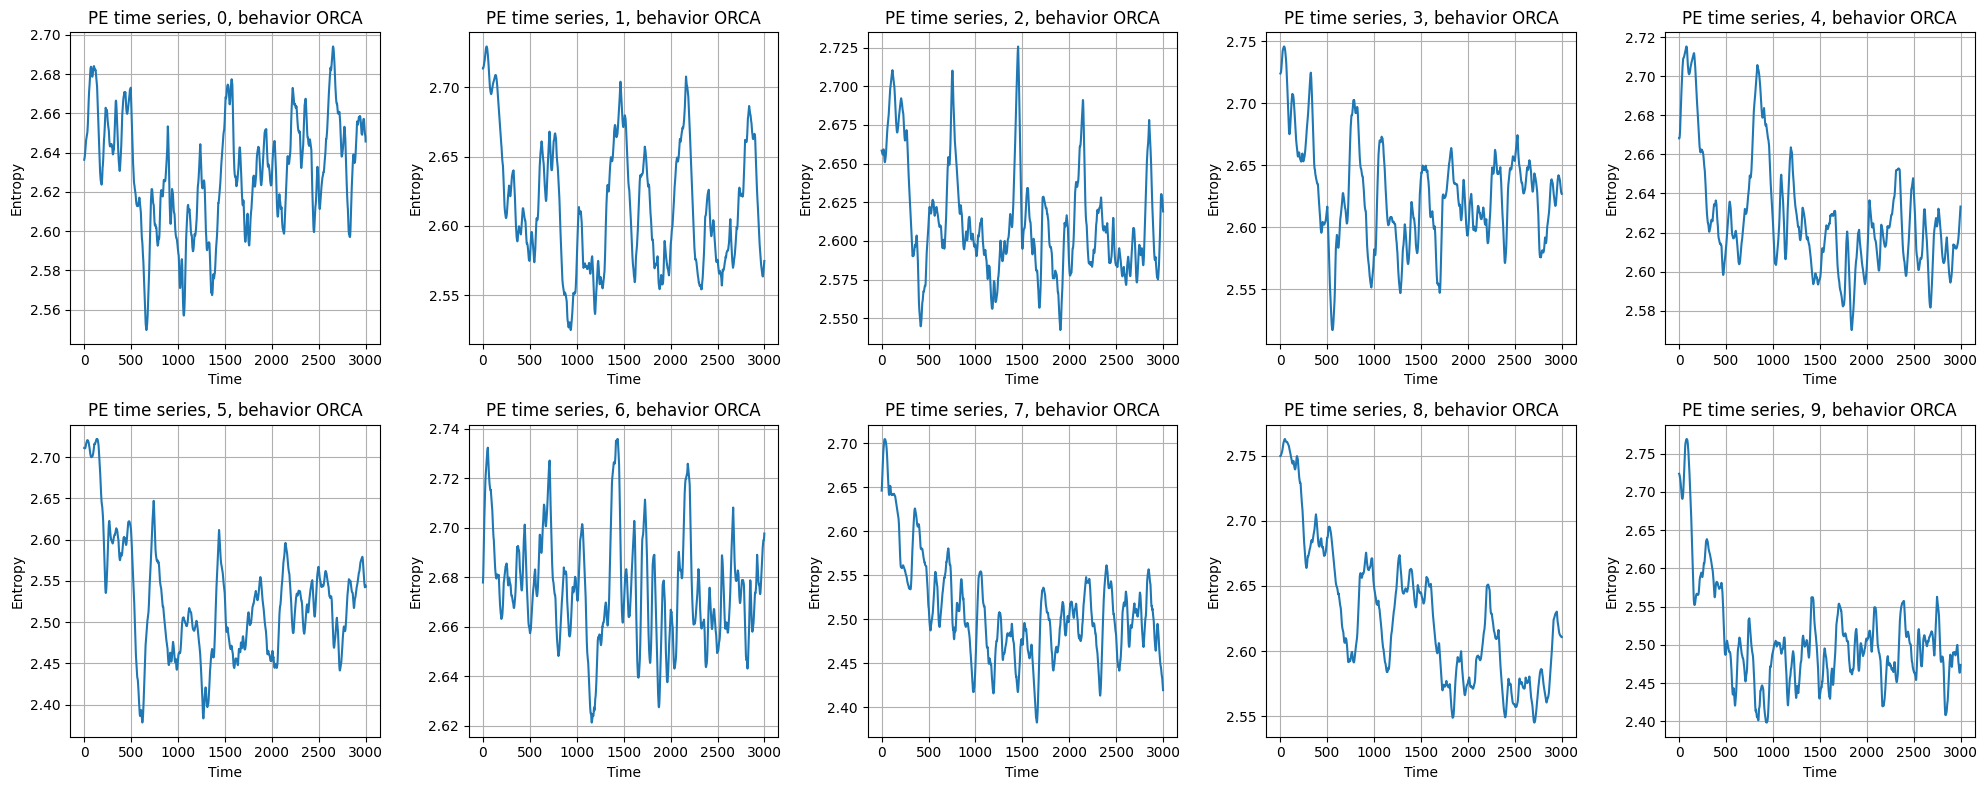

In [4]:
dfHL['persistentEntropy'] = None
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for i in tqdm(range(simulations)):
    run = experimentHL.runs[i]
    ps = run.poses
    maxd = [float(np.max(distance_matrix(X,X))) for X in ps[:,:,:2]]
    entropies=[]
    for j in range(time_instances):
        persistence = fu.ComputePersistenceDiagram(ps,j,0,"rips")
        persistenceL = fu.limitingDiagram(persistence,maxd[j])
        entropies.append(fu.EntropyCalculationFromBarcode(persistenceL))
    dfHL.at[i, 'persistentEntropy'] = np.array(entropies)

    plt.sca(axes[i])
    fu.plotEntropyTimeSerie(entropies)
    plt.title(f'PE time series, {i}, behavior ORCA')
plt.tight_layout()
plt.savefig(f'Images/{scenario}EntropyTimeSeriesHL.png', dpi=300, bbox_inches='tight')
plt.show()

Now, for the ORCA behavior

In [5]:
yaml = f"""
steps: {time_instances}
time_step: {time_step}
runs: {simulations}
record_pose: true
record_twist: true
record_colllisions: true
record_deadlocks: true
record_efficacy: true
scenario:
    type: {scenario}
    agent_margin: 0.1
    side: {sideLength}
    target_margin: 0.5
    tolerance: 0.25
    groups:
      -
        type: thymio 
        number: {robots}
        radius: {radioRobot}
        control_period: 0.1
        speed_tolerance: 0.02
        kinematics:
          type: 2WDiff
          wheel_axis: 0.094
          max_speed: 0.166
        behavior:
          type: ORCA
          safety_margin: 
            sampler: uniform
            from: 0.0
            to: 0.5
            once: true
        state_estimation:
          type: Bounded
          range: {radioVision}
"""

experimentORCA = sim.load_experiment(yaml)
wORCA = sim.World()
experimentORCA.scenario.init_world(wORCA,seed=1)
experimentORCA.run()

In [6]:
dfORCA = fu.extract_data(experimentORCA, "ORCA")
dfORCA

,seeds,safety_margin,deadlocks,collisions,efficacy,safe,fluid,ok
0,0,0.274407,0,0,0.486033,1,1,1
1,1,0.208511,0,0,0.685887,1,1,1
2,2,0.217997,0,0,0.704306,1,1,1
3,3,0.275399,0,0,0.775693,1,1,1
4,4,0.483515,0,0,0.449533,1,1,1
5,5,0.110997,0,0,0.866814,1,1,1
6,6,0.446430,0,0,0.473240,1,1,1
7,7,0.038154,0,0,0.922264,1,1,1
8,8,0.436715,0,0,0.607452,1,1,1
9,9,0.005187,0,0,0.925093,1,1,1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [32:22<00:00, 194.23s/it]


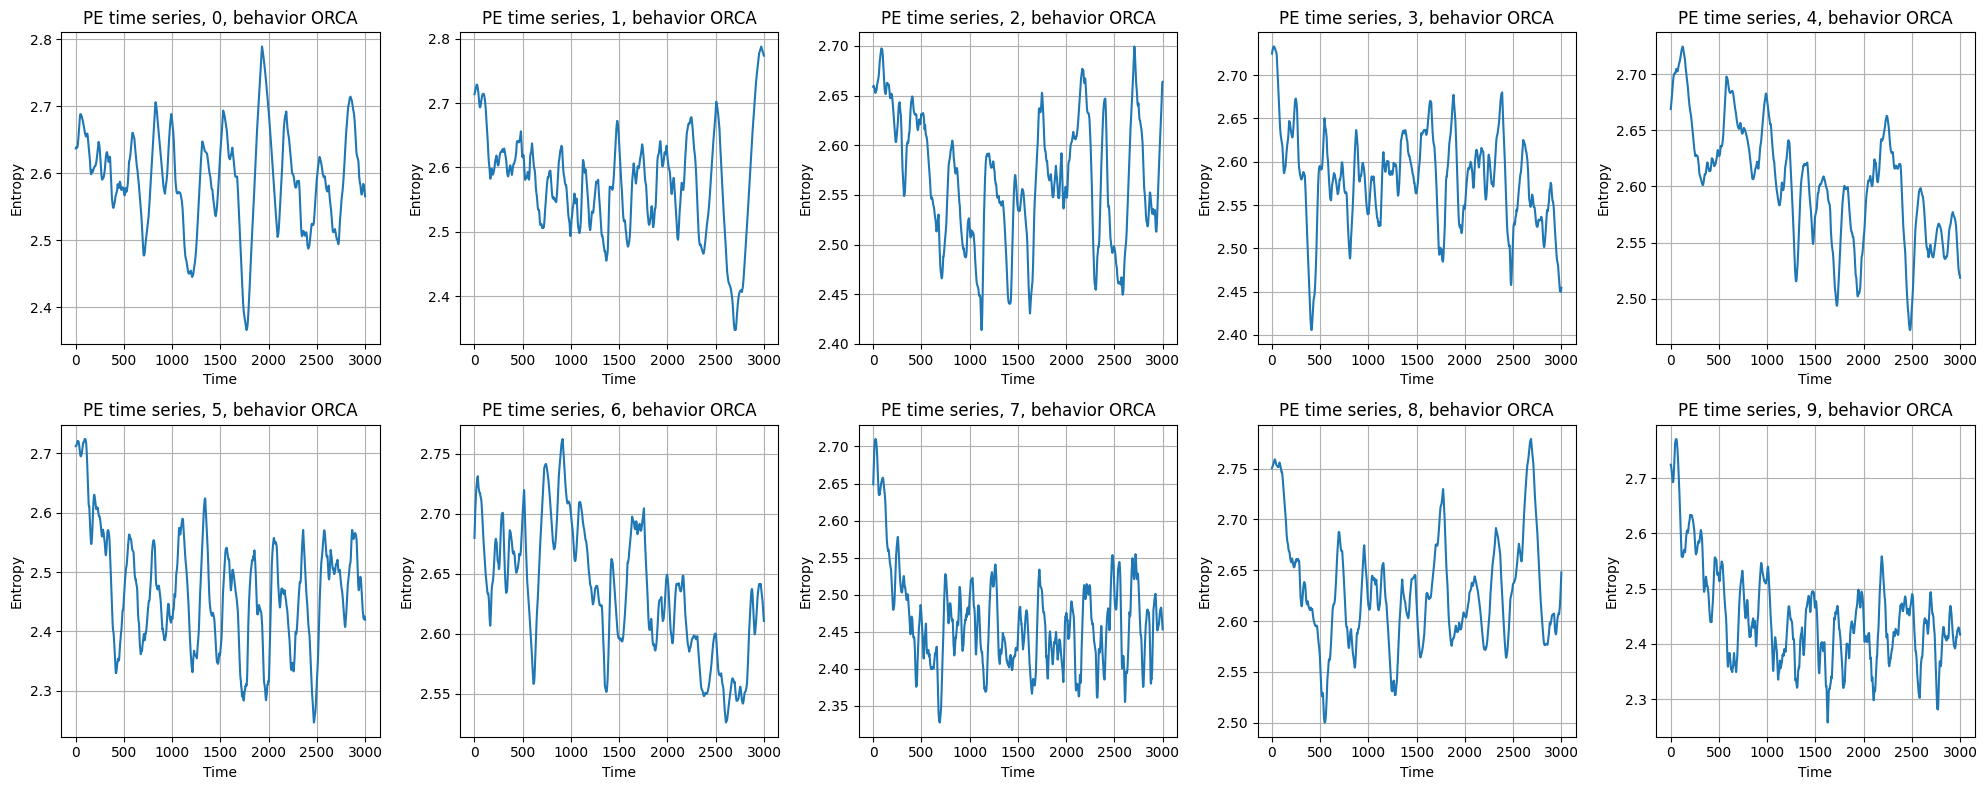

In [7]:
dfORCA['persistentEntropy'] = None
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for i in tqdm(range(simulations)):
    run = experimentORCA.runs[i]
    ps = run.poses
    maxd = [float(np.max(distance_matrix(X,X))) for X in ps[:,:,:2]]
    entropies=[]
    for j in range(time_instances):
        persistence = fu.ComputePersistenceDiagram(ps,j,0,"rips")
        persistenceL = fu.limitingDiagram(persistence,maxd[j])
        entropies.append(fu.EntropyCalculationFromBarcode(persistenceL))
    dfORCA.at[i, 'persistentEntropy'] = np.array(entropies)

    plt.sca(axes[i])
    fu.plotEntropyTimeSerie(entropies)
    plt.title(f'PE time series, {i}, behavior ORCA')
plt.tight_layout()
plt.savefig(f'Images/{scenario}EntropyTimeSeriesORCA.png', dpi=300, bbox_inches='tight')
plt.show()

With that, we can analyse the persistent entropy time series for the two behaviors and extract some conclusions.

"Human-Like" behaviour tends to exhibit greater stability, consistency and regularity in its entropy time series. On the other hand, the "ORCA" behaviour shows greater variability, with more irregular oscillations and more abrupt transitions. These differences suggest that robots under the "Human-Like" behaviour operate in a more predictable and stable manner, while those with the "ORCA" behaviour exhibit more complex dynamics and possibly more adaptive or sensitive to changes in the environment.

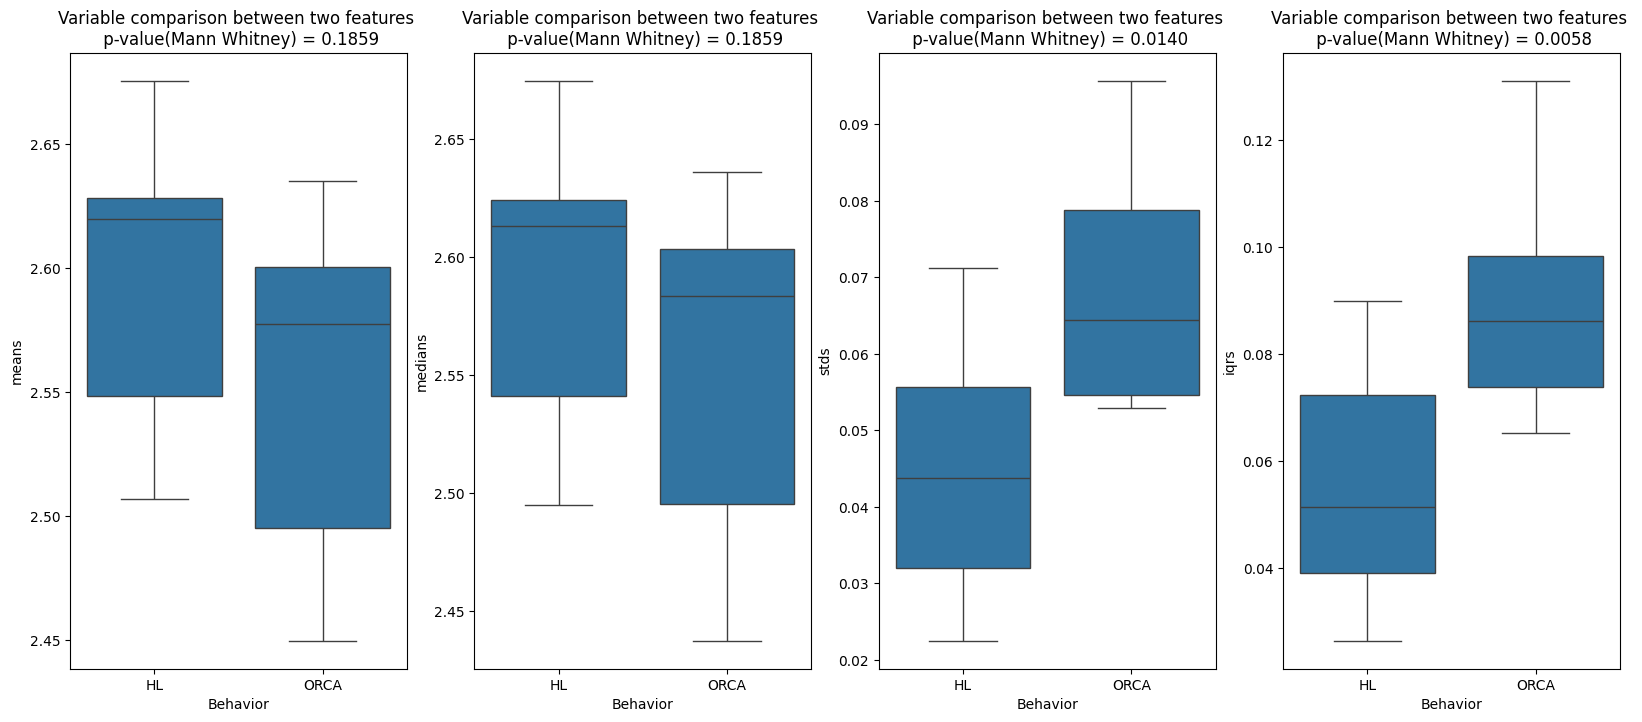

In [44]:
meansHL=[]
mediansHL=[]
stdsHL=[]
iqrsHL=[]

meansORCA=[]
mediansORCA=[]
stdsORCA=[]
iqrsORCA=[]

for j in range(simulations):
    timeserie=dfHL["persistentEntropy"].values[j]
    meansHL.append(timeserie.mean())
    mediansHL.append(np.median(timeserie))
    stdsHL.append(timeserie.std())
    iqrsHL.append(iqr(timeserie))
    timeserie=dfORCA["persistentEntropy"].values[j]
    meansORCA.append(timeserie.mean())
    mediansORCA.append(np.median(timeserie))
    stdsORCA.append(timeserie.std())
    iqrsORCA.append(iqr(timeserie))

data = pd.DataFrame({
    'means': meansHL + meansORCA,
    'medians': mediansHL + mediansORCA,
    'stds': stdsHL+ stdsORCA,
    'iqrs': iqrsHL + iqrsORCA,
    'behavior': ['HL']*simulations + ['ORCA']*simulations
})

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(["means","medians","stds","iqrs"]):
    hlvalues = data[data["behavior"] == "HL"][i].values
    orcavalues = data[data["behavior"] == "ORCA"][i].values
    u_stat, p_value = mannwhitneyu(hlvalues, orcavalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='behavior', y=i, data=data)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value:.4f}')
    plt.xlabel("Behavior")
    plt.ylabel(i)

plt.savefig(f'Images/{scenario}_boxplotBehaviors.png', dpi=300, bbox_inches='tight')
plt.show()